In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from docplex.mp.model import Model
# from NPG_CMDP import CMDP_NPG
# from ARNPG_CMDP import CMDP_ARNPG
from MARL import MARL_agent, MO_MARL

# Random Seed
np.random.seed(10)

In [19]:
from MARL import MARL_agent
n = 3
a = 3
s = 5
gamma = 0.8

A = a**n

# Randomly generated probability transition matrix P((s,a) -> s') in [0,1]^{|S||A| x |S|}
raw_transition = np.random.uniform(0, 1, size=(s * A, s))

# raw_transition = np.ones((s * A, s))
prob_transition = raw_transition / raw_transition.sum(axis=1, keepdims=1)

# Random positive rewards
reward = np.random.uniform(0, 1, size=(s * A))
rewards = [reward]

# Start state distribution
rho = np.ones(s) / s

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.92it/s]


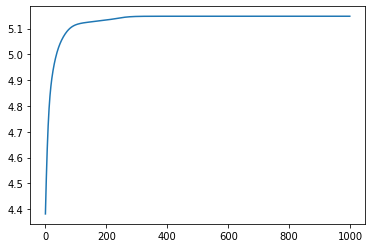

In [20]:
temp = MARL_agent(rewards, s, a, rho, gamma, n, prob_transition, tau=0.1)
temp.step = 0.1
temp.theta = np.zeros(shape=n* s* a)

N = 1000
for i in tqdm(range(N)):
#   temp.NPG_entropy_step(verbose=False)
    A_tildes, pi, V_tau, A_tau = temp.NPG_entropy_step_change(verbose=False)

plt.plot(temp.gap)

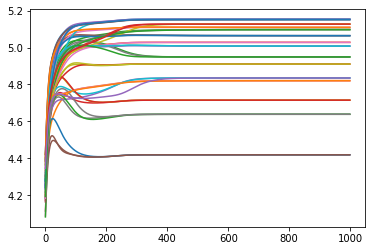

In [21]:
# check monotonicity of tilde{Q}
plt.plot(temp.Q_tilde)

In [22]:
# #check monotonicity of V_{tau}
# for i in range(0,len(temp.gap)-1):
#     temp.gap[i] -= temp.gap[i+1]
# plt.plot(temp.gap[0:90])
# print(np.max(temp.gap[0:90]))

In [23]:
# approximate optimal value via soft q-iteration
temp_opt = MARL_agent(rewards, s, a, rho, gamma, n, prob_transition, tau=0.1)
temp.step = 0.1
temp.theta = np.zeros(shape=n* s* a)
ell_star, A_tildes_opt, pi_opt, V_tau_opt = temp_opt.solver(typ='global')
print(ell_star)

5.147695662386122


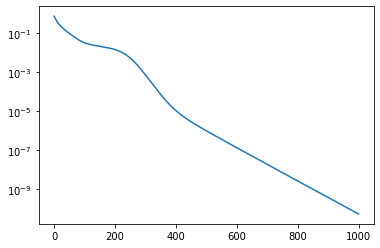

In [25]:
# judge convergence rate via log plot
opt_gap = [ell_star - gap for gap in temp.gap]
plt.axes(yscale='log')
# plt.axes(xscale='log')
plt.plot(opt_gap)

In [28]:
# check middle results
print('Atildes', A_tildes)
print('pi', pi)
print('Vtau', V_tau)
print('Atau', A_tau)
print('test', np.dot(A_tildes[0], pi[0:s*a]))

Atildes [array([-8.92475619e-07, -5.00732273e-07,  1.20632826e-06,  1.11887442e-11,
       -1.43486799e-13,  6.28522131e-12,  1.81127436e-10,  5.81685214e-10,
       -6.26340101e-10, -3.65720184e-07,  7.73524348e-08,  2.60155419e-07,
       -1.03564154e-10,  1.53847518e-11,  3.81342893e-11]), array([ 1.78889939e-07, -2.96956932e-06, -2.75598787e-06, -2.95467692e-13,
        1.06453595e-11,  3.70278135e-12,  6.48413354e-12, -1.19706242e-09,
        3.33064982e-10, -6.88274682e-07, -1.55555671e-07,  1.38194158e-07,
       -1.33388281e-10, -1.40880947e-10,  1.33612954e-11]), array([-2.68332589e-06,  1.54095025e-07, -3.78305037e-06, -1.58565003e-12,
        4.26576895e-12,  8.60854424e-13, -4.29821845e-10,  4.71480639e-10,
       -2.73136344e-10,  1.00110075e-07,  1.61097360e-07, -8.60796319e-08,
       -1.88954036e-10,  1.06419409e-12, -3.42655498e-10])]
pi [2.52778470e-01 3.95882755e-01 3.51338775e-01 1.22255005e-02
 9.87143523e-01 6.30976781e-04 7.52930266e-01 1.52083348e-02
 2.31861399

In [10]:
def cal_Q_tildes(Atildes, Pi, Vtau, tau=0.1):
    Q_tildes = np.zeros(n*s*a)
    for agent in range(n):
        for state in range(s):
            Q_tildes[agent*s*a+state*a:agent*s*a+(state+1)*a] = Atildes[agent][state*a:(state+1)*a] 
            + tau * np.log(Pi[state*a:(state+1)*a]) + Vtau[state]
    return Q_tildes
            
Q_tildes = cal_Q_tildes(A_tildes, pi, V_tau, 0.1)
Q_tildes_opt = cal_Q_tildes(A_tildes_opt, pi_opt, V_tau_opt, 0.1)
print(max(np.abs(Q_tildes - Q_tildes_opt)))

0.00760697948977569


In [11]:
def Q_cal(V, func):
    Q = np.zeros(s * A)
    for i in range(s):
        for j in range(A):
            Q[i * A + j] = func[i * A + j] + gamma * np.matmul(prob_transition[i * A + j], V)
    return Q

Q = Q_cal(V_tau, reward)
Q_opt = Q_cal(V_tau_opt, reward)
print(max(np.abs(Q - Q_opt)))

2.125484575365988e-05


In [5]:
prob = temp.theta_to_policy()
Pi = temp.get_Pi(prob)
mat = np.identity(temp.s * temp.A) - temp.gamma * np.matmul(temp.prob_transition, Pi)
P_theta = np.matmul(Pi, temp.prob_transition) # |S|*|S|
d_pi = (1 - temp.gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(temp.s) - temp.gamma * P_theta))), temp.rho)

print(temp.theta)
print(prob)

[2.32789176 1.42730195 0.         0.17390555 0.35655456 0.38287269
 0.20226845 0.22354205]
[0.71107069 0.28892931 0.45663285 0.54336715 0.49342085 0.50657915
 0.4946818  0.5053182 ]


In [ ]:
N = 500
ax1 = plt.subplot(211)
# ax1.plot(t, np.sin(2*np.pi*t))

ax2 = plt.subplot(212, sharex=ax1)
# ax2.plot(t, np.sin(4*np.pi*t))

for j in range(5):
    temp = MO_MARL(rewards, s, a, rho, gamma, n, prob_transition)
    for i in tqdm(range(N)):
        temp.Centralized_NPG_step(verbose = False)
    ax1.plot(temp.gap)
    ax2.plot(temp.avg_gap)
    
plt.show()
    

 32%|███▏      | 158/500 [00:01<00:02, 140.39it/s]

In [14]:
agent_num = 5
Laplacian = np.zeros((agent_num, agent_num))

for i in range(agent_num):
    Laplacian[i,i] = -2
    Laplacian[i,(i+1)%agent_num] = 1
    Laplacian[i,(i-1)%agent_num] = 1
print(Laplacian)

W = np.zeros((agent_num, agent_num))
eta = 0.1
for i in range(agent_num):
    W[i,i] = 1-2*eta
    W[i,(i+1)%agent_num] = eta
    W[i,(i-1)%agent_num] = eta
print(W)



[[-2.  1.  0.  0.  1.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 1.  0.  0.  1. -2.]]
[[0.8 0.1 0.  0.  0.1]
 [0.1 0.8 0.1 0.  0. ]
 [0.  0.1 0.8 0.1 0. ]
 [0.  0.  0.1 0.8 0.1]
 [0.1 0.  0.  0.1 0.8]]


In [9]:
agent_list = []
for i in range(agent_num):
    agent_list.append(MO_MARL(rewards, s, a, rho, gamma, n, prob_transition))
# for k in range(5):
old_grad = np.zeros((agent_num, reward_num))
grad = np.zeros((agent_num, reward_num))
y = np.zeros((agent_num, reward_num))
all_theta = np.zeros((agent_num, n*s*a))
N = 1000
for k in tqdm(range(N)):
    
    for i in range(agent_num):
        grad[i] = agent_list[i].calculate_G(num=i,verbose = False)
        all_theta[i] = copy.deepcopy(agent_list[i].theta)

    y = W@y+grad-old_grad
#     y = W@grad
#     y = copy.deepcopy(grad)
#     y = y + eta*Laplacian@grad
    old_grad = copy.deepcopy(grad)
    all_theta = W@all_theta
        
    for i in range(agent_num):
        agent_list[i].theta=all_theta[i]
        agent_list[i].NPG_step_given_G(y[i], verbose = False)
        

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:07<00:00,  2.72it/s]


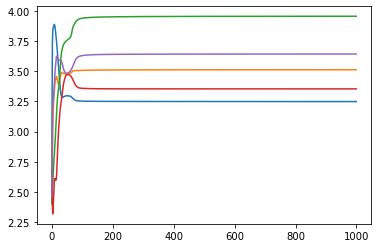

In [10]:
# plt.plot(agent_list[0].Q_record)
plt.plot(agent_list[0].V_record[0])
plt.plot(agent_list[0].V_record[1])
plt.plot(agent_list[0].V_record[2])
plt.plot(agent_list[0].V_record[3])
plt.plot(agent_list[0].V_record[4])

6.313887881586048
6.266685230417442
6.30454248226258
6.367220519322908
6.312252667057926


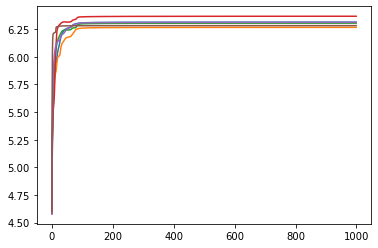

In [13]:
# plt.plot(agent_list[0].gap)

for i in range(agent_num):
    plt.plot(agent_list[i].gap)
    print(agent_list[i].gap[-1])
plt.plot(temp.gap)